In [1]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/lindi/chenhr/threed/pointnet++/seg')
from pointnet2_seg_amp import Pointnet2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from dataset import S3dis
from data_aug import Compose, PointCloudFloorCentering, ColorNormalize
from torch.utils.data import DataLoader

val_aug = Compose([PointCloudFloorCentering(),
                        ColorNormalize()])
val_dataset = S3dis('/home/lindi/chenhr/threed/data/processed_s3dis', split='train', loop=1, npoints=24000, transforms=val_aug)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)

val_dataloader = iter(val_dataloader)
for i in range(1):
    pos, x, y = next(val_dataloader)

device = 'cuda:7'

pos = pos.to(device)
x = x.to(device)
y = y.to(device)

print(pos.shape, x.shape, y.shape)

torch.Size([64, 24000, 3]) torch.Size([64, 24000, 3]) torch.Size([64, 24000])


In [3]:
def gen_color(y):
    """
    y.shape = (n,) cuda
    """
    y = y.to('cpu').squeeze()
    color_map = [[0, 255, 0], [0, 0, 255], [136, 206, 250],
                 [255, 255, 0], [255, 0, 255], [255, 0, 0],
                 [107, 142, 35], [255, 165, 0], [153, 50, 204],
                 [139, 26, 26], [0, 100, 0], [156, 156, 156], [0, 0, 0]]
    color_map = torch.as_tensor(color_map, dtype=torch.float32)
    res = torch.zeros((len(y), 3))
    for i in range(13):
        mask = (y == i)
        res[mask] = color_map[i]
    return res

/home/lindi/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(82392, 2)


([], [])

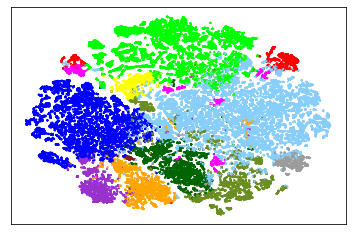

In [4]:
model = Pointnet2(13).to(device)
model.eval()
model_path = '/home/lindi/chenhr/threed/pointnet++/seg/checkpoints/pointnet2_seg_amp.pth'
model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])

with torch.no_grad():
    _, x4, y4 = model(pos, x, y)

# flatten
x4 = x4.flatten(0, 1)
y4 = y4.flatten(0, 1)

# 过滤一些类别
mask = (y4 != 12)
x4, y4 = x4[mask], y4[mask]

y_color = gen_color(y4) / 255  # (n, 3)
x4 = x4.squeeze().to('cpu').numpy()   # (n, c)

tsne = TSNE(init='pca', learning_rate=200, perplexity=50, n_iter=1000, random_state=4464)
low_f = tsne.fit_transform(x4)
print(low_f.shape)

plt.scatter(low_f[:, 0], low_f[:, 1], c=y_color, s=1)
plt.xticks([])
plt.yticks([])

/home/lindi/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(82392, 2)


([], [])

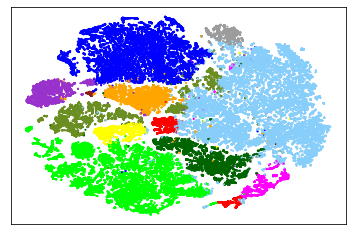

: 

In [7]:
from memorynet_seg_x3x2_contrast import Memorynet

model = Memorynet(13).to(device)
model.eval()
model_path = '/home/lindi/chenhr/threed/pointnet++/seg/checkpoints/memorynet_seg_x3x2_contrast_1tao.pth'
model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])

with torch.no_grad():
    _, _, _, x4, y4 = model(pos, x, y)
    
# flatten
x4 = x4.flatten(0, 1)
y4 = y4.flatten(0, 1)

# 过滤一些类别
mask = (y4 != 12)
x4, y4 = x4[mask], y4[mask]
    
y_color = gen_color(y4) / 255  # (n, 3)
x4 = x4.squeeze().to('cpu').numpy()   # (n, c)

tsne = TSNE(init='pca', learning_rate=200, perplexity=50, n_iter=1000)
low_f = tsne.fit_transform(x4)
print(low_f.shape)

plt.scatter(low_f[:, 0], low_f[:, 1], c=y_color, s=1)
plt.xticks([])
plt.yticks([])